In [1]:
import os
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
from torch.amp import autocast, GradScaler # Use 'cuda' specific autocast
from tqdm import tqdm
import matplotlib.pyplot as plt
import time # To measure training time

In [ ]:

# --- Configuration ---
DATA_DIR = 'dataset/images'  # expects subfolders train/, val/, test/
BATCH_SIZE = 32 # Increased batch size for potentially faster training, adjust based on GPU memory
NUM_EPOCHS = 5
MODEL_SAVE_PATH = 'efficientnet_v2s_finetuned.pth' # Path to save the final model
mapping_save_path = 'class_mapping.json'

# --- Device Setup ---
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    # Enable cuDNN benchmark for potentially faster convolutions on fixed input sizes
    torch.backends.cudnn.benchmark = True
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")

# --- Determine Number of Classes ---
try:
    train_dir = os.path.join(DATA_DIR, 'train')
    if not os.path.isdir(train_dir):
        raise FileNotFoundError(f"Training directory not found: {train_dir}")
    classes = os.listdir(train_dir)
    # Filter out potential hidden files/dirs like .DS_Store
    classes = [d for d in classes if os.path.isdir(os.path.join(train_dir, d))]
    NUM_CLASSES = len(classes)
    if NUM_CLASSES == 0:
        raise ValueError(f"No subdirectories found in {train_dir}. Expected class folders.")
    print(f"Found {NUM_CLASSES} classes: {classes}")
except Exception as e:
    print(f"Error determining number of classes: {e}")
    print("Please ensure DATA_DIR points to a directory containing 'train', 'val', and 'test' subfolders,")
    print("and that 'train' contains one subfolder per class.")
    exit() # Exit if class setup fails
# --- Preprocessing ---
# Use the recommended weights and transforms for EfficientNet-B0
# --- Preprocessing ---
weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1
img_size = 384 # Standard EfficientNet-B0 input size from weights.transforms()

# Define separate transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)), # Crop differently each time
    transforms.RandomHorizontalFlip(p=0.5),                  # Flip images horizontally sometimes
    transforms.RandomRotation(degrees=15),                    # Rotate slightly
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Adjust colors
    transforms.ToTensor(),
    # Use normalization parameters from the pre-trained weights
    transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0) # Optional: Cutout/Random Erasing
])

# Keep validation/test transform simpler (usually matching evaluation protocol)
val_test_transform = weights.transforms() # Use the standard transforms for val/test
# --- Datasets and Loaders ---
print("Loading datasets...")
try:
    train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_transform)
    val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), transform=val_test_transform)
    test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=val_test_transform)

    # Check if datasets are empty
    if not train_dataset or not val_dataset or not test_dataset:
         raise ValueError("One or more datasets (train, val, test) are empty or could not be loaded.")

    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

    # Pin memory for faster CPU to GPU transfers if using CUDA
    pin_memory = True if DEVICE == torch.device("cuda") else False

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=pin_memory)
    print("DataLoaders created.")

    # Determine number of classes and save mapping
    num_classes = len(train_dataset.classes)
    class_mapping = train_dataset.class_to_idx
    print(f"Found {num_classes} classes: {train_dataset.classes}")

    # Save class mapping
    try:
        with open(mapping_save_path, 'w') as f:
            json.dump(class_mapping, f, indent=4)
        print(f"Class mapping saved to: {mapping_save_path}")
    except IOError as e:
        print(f"Warning: Could not save class mapping to {mapping_save_path}: {e}")

except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure 'train', 'val', and 'test' subdirectories exist in DATA_DIR and contain images.")
    exit()

In [ ]:

# --- Model Definition ---
print("Loading EfficientNet-B0 model...")
model = efficientnet_v2_s(weights=weights)

# Replace the final fully connected layer (classifier)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Dropout(p=0.37, inplace=True), # Keep dropout
    nn.Linear(num_ftrs, NUM_CLASSES),
)
model.to(DEVICE)
print(f"Model classifier modified for {NUM_CLASSES} classes.")
from torch.optim.lr_scheduler import ReduceLROnPlateau
# --- Loss and Optimizer ---
criterion = nn.CrossEntropyLoss()
# Use AdamW which often works better with transformers and modern architectures
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=6e-2)
# Optional: Learning Rate Scheduler (e.g., reduce on plateau)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)
# Factor: Multiplies LR by this (0.1 = reduce to 10%)
# Patience: Number of epochs with no improvement after which LR is reduced.

# --- Mixed Precision Setup ---
# Only use GradScaler if on CUDA
scaler = GradScaler("cuda")
print(f"Mixed precision enabled: {scaler.is_enabled()}")


--- Starting Training ---


[Epoch 1] Train Loss: 2.1896, Accuracy: 0.5636


[Epoch 1] Validation Accuracy: 0.8423
Validation accuracy improved from 0.0000 to 0.8423. Saving best model...


[Epoch 2] Train Loss: 0.6165, Accuracy: 0.8556


[Epoch 2] Validation Accuracy: 0.8893
Validation accuracy improved from 0.8423 to 0.8893. Saving best model...


[Epoch 3] Train Loss: 0.3389, Accuracy: 0.9133


[Epoch 3] Validation Accuracy: 0.9030
Validation accuracy improved from 0.8893 to 0.9030. Saving best model...


[Epoch 4] Train Loss: 0.2165, Accuracy: 0.9441


[Epoch 4] Validation Accuracy: 0.9089
Validation accuracy improved from 0.9030 to 0.9089. Saving best model...


[Epoch 5] Train Loss: 0.1613, Accuracy: 0.9533


[Epoch 5] Validation Accuracy: 0.8981

--- Training Finished ---
Total Training Time: 9.26 minutes

--- Plotting Metrics ---
Metrics plot saved as training_validation_metrics.png


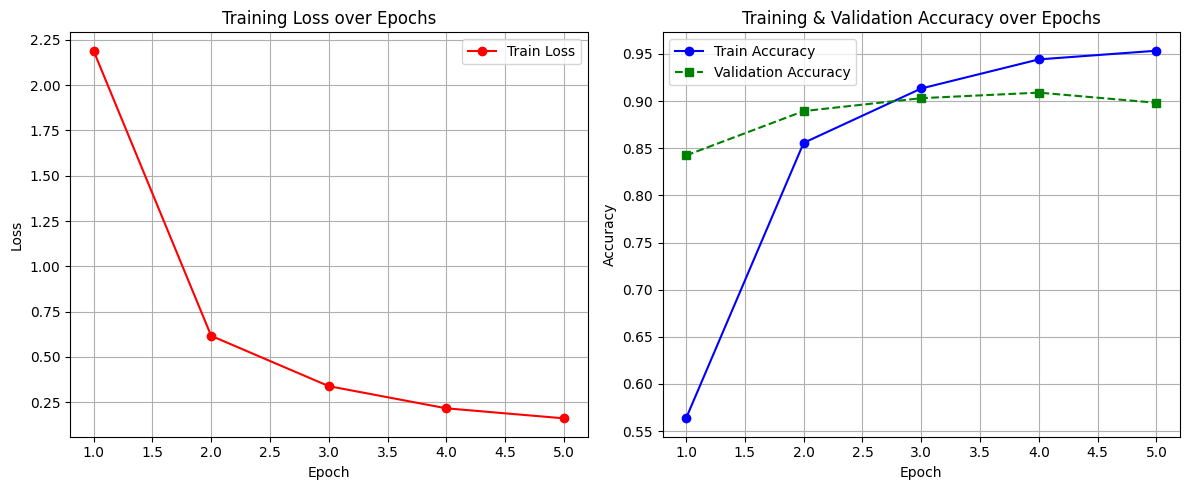


--- Evaluating on Test Set ---
Loading best model weights for final testing...


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_25296\2738317448.py:148: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth', map_lo

[Epoch Final] Testing (Best Model) Accuracy: 0.9099

Final Test Accuracy (Best Model): 0.9099


In [2]:
# Lists to store metrics for plotting
train_losses, val_accuracies, train_accuracies = [], [], []

# --- Training Function ---
def train_one_epoch(epoch_num):
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch_num}/{NUM_EPOCHS} [Training]", leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()

        # Use autocast only if on CUDA
        with autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Scales loss. Calls backward() on scaled loss to create scaled gradients.
        scaler.scale(loss).backward()

        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called.
        # Otherwise, optimizer.step() is skipped.
        scaler.step(optimizer)

        # Updates the scale for next iteration.
        scaler.update()

        running_loss += loss.item() * inputs.size(0) # Accumulate loss correctly
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Update progress bar postfix
        batch_acc = (predicted == labels).sum().item() / labels.size(0)
        progress_bar.set_postfix(loss=loss.item(), acc=f"{batch_acc:.4f}")

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    print(f"[Epoch {epoch_num}] Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc

# --- Validation Function ---
@torch.no_grad() # No need to track gradients during evaluation
def evaluate(data_loader, epoch_num=None, phase="Validation"):
    model.eval() # Set model to evaluation mode
    correct_predictions = 0
    total_samples = 0

    desc = f"Epoch {epoch_num if epoch_num else '?'} [{phase}]"
    progress_bar = tqdm(data_loader, desc=desc, leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        # Use autocast for potential speedup even during inference on CUDA
        with autocast("cuda"):
            outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        batch_acc = (predicted == labels).sum().item() / labels.size(0)
        progress_bar.set_postfix(acc=f"{batch_acc:.4f}")


    accuracy = correct_predictions / total_samples
    print(f"[Epoch {epoch_num if epoch_num else 'Final'}] {phase} Accuracy: {accuracy:.4f}")
    return accuracy

# --- Plotting Function ---
def plot_metrics():
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss', marker='o', linestyle='-', color='r')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o', linestyle='-', color='b')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='s', linestyle='--', color='g')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.savefig("training_validation_metrics.png") # Save the plot
    print("Metrics plot saved as training_validation_metrics.png")
    plt.show() # Display the plot

# --- Main Execution ---
print("\n--- Starting Training ---")
start_time = time.time()

best_val_acc = 0.0 # Keep track of best validation accuracy for potential early stopping or saving best model

for epoch in range(1, NUM_EPOCHS + 1):
    # Train for one epoch
    train_loss, train_acc = train_one_epoch(epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on validation set
    val_acc = evaluate(val_loader, epoch_num=epoch, phase="Validation")
    val_accuracies.append(val_acc)

    # Optional: Implement learning rate scheduling based on validation loss/accuracy
    if scheduler: 
        scheduler.step(val_acc) # Or val_acc if using ReduceLROnPlateau with mode='max'

    # Optional: Save the model checkpoint if it has the best validation accuracy so far
    if val_acc > best_val_acc:
        print(f"Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}. Saving best model...")
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')


end_time = time.time()
print(f"\n--- Training Finished ---")
print(f"Total Training Time: {(end_time - start_time) / 60:.2f} minutes")

# --- Plot Training and Validation Metrics ---
print("\n--- Plotting Metrics ---")
plot_metrics()

# --- Testing the Model ---
print("\n--- Evaluating on Test Set ---")
# Option 1: Evaluate the final model after all epochs
# test_accuracy = evaluate(test_loader, phase="Testing")

# Option 2: Load the best model (based on validation accuracy) and test that
print("Loading best model weights for final testing...")
try:
    model.load_state_dict(torch.load('best_model.pth', map_location=DEVICE))
    test_accuracy = evaluate(test_loader, phase="Testing (Best Model)")
    print(f"\nFinal Test Accuracy (Best Model): {test_accuracy:.4f}")
except FileNotFoundError:
    print("Warning: 'best_model.pth' not found. Testing the model from the final epoch.")
    test_accuracy = evaluate(test_loader, phase="Testing (Final Epoch Model)")
    print(f"\nFinal Test Accuracy (Final Epoch Model): {test_accuracy:.4f}")

### EfficientNetB4 training

In [8]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
from torch.amp import autocast, GradScaler # Use 'cuda' specific autocast
from tqdm import tqdm
import matplotlib.pyplot as plt
import time # To measure training time

# --- Configuration ---
DATA_DIR = 'dataset/images'  # expects subfolders train/, val/, test/
BATCH_SIZE = 32 # Increased batch size for potentially faster training, adjust based on GPU memory
MODEL_SAVE_PATH = 'efficientnet_b4_finetuned.pth' # Path to save the final model

# --- Device Setup ---
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
    # Enable cuDNN benchmark for potentially faster convolutions on fixed input sizes
    torch.backends.cudnn.benchmark = True
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")

# --- Determine Number of Classes ---
try:
    train_dir = os.path.join(DATA_DIR, 'train')
    if not os.path.isdir(train_dir):
        raise FileNotFoundError(f"Training directory not found: {train_dir}")
    classes = os.listdir(train_dir)
    # Filter out potential hidden files/dirs like .DS_Store
    classes = [d for d in classes if os.path.isdir(os.path.join(train_dir, d))]
    NUM_CLASSES = len(classes)
    if NUM_CLASSES == 0:
        raise ValueError(f"No subdirectories found in {train_dir}. Expected class folders.")
    print(f"Found {NUM_CLASSES} classes: {classes}")
except Exception as e:
    print(f"Error determining number of classes: {e}")
    print("Please ensure DATA_DIR points to a directory containing 'train', 'val', and 'test' subfolders,")
    print("and that 'train' contains one subfolder per class.")
    exit() # Exit if class setup fails
# --- Preprocessing ---
# Use the recommended weights and transforms for EfficientNet-B4
# --- Preprocessing ---
weights = EfficientNet_B4_Weights.IMAGENET1K_V1
img_size = 384 # Standard EfficientNet-B4 input size from weights.transforms()

# Define separate transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)), # Crop differently each time
    transforms.RandomHorizontalFlip(p=0.5),                  # Flip images horizontally sometimes
    transforms.RandomRotation(degrees=15),                    # Rotate slightly
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Adjust colors
    transforms.ToTensor(),
    # Use normalization parameters from the pre-trained weights
    transforms.Normalize(mean=weights.transforms().mean, std=weights.transforms().std),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0) # Optional: Cutout/Random Erasing
])

# Keep validation/test transform simpler (usually matching evaluation protocol)
val_test_transform = weights.transforms() # Use the standard transforms for val/test
# --- Datasets and Loaders ---
print("Loading datasets...")
try:
    train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_transform)
    val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'val'), transform=val_test_transform)
    test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=val_test_transform)

    # Check if datasets are empty
    if not train_dataset or not val_dataset or not test_dataset:
         raise ValueError("One or more datasets (train, val, test) are empty or could not be loaded.")

    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

    # Pin memory for faster CPU to GPU transfers if using CUDA
    pin_memory = True if DEVICE == torch.device("cuda") else False

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=pin_memory)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=pin_memory)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=pin_memory)
    print("DataLoaders created.")

except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure 'train', 'val', and 'test' subdirectories exist in DATA_DIR and contain images.")
    exit()

# --- Model Definition ---
print("Loading EfficientNet-B4 model...")
# Replace the final fully connected layer (classifier)
model = efficientnet_b4(weights=weights)

# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

# --- Unfreeze later layers ---
# Example: Unfreeze the last feature block(s). You might need to inspect
# model.features to find the correct indices/names for EfficientNet-B4.
# Let's assume the last block is index 8 (check this structure!)
# for block_index in [8]: # Or maybe [7, 8] for last two blocks
#     try:
#         for param in model.features[block_index].parameters():
#              param.requires_grad = True
#         print(f"Unfrozen parameters in features block {block_index}")
#     except IndexError:
#         print(f"Warning: Could not find features block at index {block_index}")

# Replace and ensure classifier is trainable
in_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(p=0.4, inplace=True), # Keep dropout
    nn.Linear(in_features, NUM_CLASSES),
)
# This loop is technically redundant if you just replaced the classifier,
# as new layers require grad by default, but explicit is okay.  
# for param in model.classifier.parameters():
#     param.requires_grad = True

model.to(DEVICE)

Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Found 67 classes: ['Apple', 'Artichoke', 'Balaleet', 'Bamya', 'Banana', 'Basbousa', 'Bell pepper', 'bread', 'Broccoli', 'Burger', 'Carrot', 'Crab', 'Cucumber', 'Dajaj_Mahshi', 'Dates_with_tahini', 'Fattoush', 'Fries', 'Gers_Ogaily', 'Grape', 'Harees', 'Hot Dog', 'Hummus', 'Jireesh', 'Kebab', 'khabeesa', 'Kubba', 'laban_drink', 'Labneh', 'Lentil_soup', 'Lentil_stew', 'Lobster', 'Luqaimat', 'Majboos_Dajaj', 'Mallooba(Maqluba)', 'Modas_rice', 'Molokhia', 'Muhammara', 'Murabyan', 'Musakhan_Chicken', 'om_ali', 'Orange (fruit)', 'Oyster', 'Peach', 'Pear', 'Pineapple', 'Pizza', 'Plain_white_rice', 'Pomegranate', 'Potato', 'Pumpkin', 'Radish', 'Red_tea_with_mint_or_saffron', 'rice_with_meat', 'Saffron', 'Samosa', 'Sandwich', 'Shrimp', 'Strawberry', 'Tabouleh', 'Taco', 'Tahini', 'Tamarind_juice', 'Tamria(Tamriyeh)', 'Tea_with_milk', 'Warak_Enab', 'Watermelon', 'Zaatar']
Loading datasets...
Train samples: 7981, Val samples: 1052, Test samples: 1364
D

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

#### Steps to solve class imbalance

In [9]:
# --- Add this section before defining the Loss and Optimizer ---
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# --- Calculate Class Weights for Weighted Loss ---
print("Calculating class weights for weighted loss...")
try:
    # Ensure train_dataset is loaded and has 'targets' attribute
    if 'train_dataset' not in locals() or not hasattr(train_dataset, 'targets'):
         raise ValueError("train_dataset object not found or missing 'targets' attribute.")

    class_labels = train_dataset.targets # Get the list of labels for each sample
    class_indices = sorted(list(set(class_labels))) # Get unique class indices (0, 1, 2...)

    # Ensure number of unique labels matches NUM_CLASSES derived from folders
    if len(class_indices) != NUM_CLASSES:
         print(f"Warning: Number of classes in targets ({len(class_indices)}) "
               f"differs from folder count ({NUM_CLASSES}). Using target count.")
         # Adjust NUM_CLASSES if necessary, or investigate the discrepancy
         # NUM_CLASSES = len(class_indices) # Uncomment carefully if needed

    # Calculate weights: higher weight for less frequent classes
    # 'balanced' mode automatically calculates weights as: n_samples / (n_classes * np.bincount(y))
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.array(class_indices), # Pass the actual unique class indices found
        y=np.array(class_labels)         # Pass all the labels
    )

    # Convert weights to a PyTorch tensor and move to the correct device
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(DEVICE)
    print(f"Class weights calculated (first 5): {class_weights_tensor[:5]}") # Print first few weights
    use_weighted_loss = True

except Exception as e:
    print(f"ERROR: Could not calculate class weights: {e}. Using standard loss.")
    use_weighted_loss = False
    class_weights_tensor = None # Ensure it's None if calculation fails

Calculating class weights for weighted loss...
Class weights calculated (first 5): tensor([0.8570, 1.5470, 1.2809, 0.8103, 0.8759], device='cuda:0')


In [11]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
# --- Loss and Optimizer ---
print("Defining Loss function...")
if use_weighted_loss:
    print("Using Weighted CrossEntropyLoss.")
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
else:
    print("Using standard CrossEntropyLoss.")
    criterion = nn.CrossEntropyLoss()

# Use AdamW which often works better with transformers and modern architectures
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-2)
# Optional: Learning Rate Scheduler (e.g., reduce on plateau)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=2, verbose=True)
# Factor: Multiplies LR by this (0.1 = reduce to 10%)
# Patience: Number of epochs with no improvement after which LR is reduced
# --- Mixed Precision Setup ---

# Only use GradScaler if on CUDA

scaler = GradScaler("cuda")

print(f"Mixed precision enabled: {scaler.is_enabled()}")

Defining Loss function...
Using Weighted CrossEntropyLoss.
Mixed precision enabled: True


c:\Work\Garbage_classification\food-recognition\food-recognition\env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [12]:
# Lists to store metrics for plotting
train_losses, val_accuracies, train_accuracies = [], [], []
NUM_EPOCHS = 100

# --- Training Function ---
def train_one_epoch(epoch_num):
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch_num}/{NUM_EPOCHS} [Training]", leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()

        # Use autocast only if on CUDA
        with autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Scales loss. Calls backward() on scaled loss to create scaled gradients.
        scaler.scale(loss).backward()

        # scaler.step() first unscales the gradients of the optimizer's assigned params.
        # If these gradients do not contain infs or NaNs, optimizer.step() is then called.
        # Otherwise, optimizer.step() is skipped.
        scaler.step(optimizer)

        # Updates the scale for next iteration.
        scaler.update()

        running_loss += loss.item() * inputs.size(0) # Accumulate loss correctly
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Update progress bar postfix
        batch_acc = (predicted == labels).sum().item() / labels.size(0)
        progress_bar.set_postfix(loss=loss.item(), acc=f"{batch_acc:.4f}")

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    print(f"[Epoch {epoch_num}] Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc

# --- Validation Function ---
@torch.no_grad() # No need to track gradients during evaluation
def evaluate(data_loader, epoch_num=None, phase="Validation"):
    model.eval() # Set model to evaluation mode
    correct_predictions = 0
    total_samples = 0

    desc = f"Epoch {epoch_num if epoch_num else '?'} [{phase}]"
    progress_bar = tqdm(data_loader, desc=desc, leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        # Use autocast for potential speedup even during inference on CUDA
        with autocast("cuda"):
            outputs = model(inputs)

        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()
        batch_acc = (predicted == labels).sum().item() / labels.size(0)
        progress_bar.set_postfix(acc=f"{batch_acc:.4f}")


    accuracy = correct_predictions / total_samples
    print(f"[Epoch {epoch_num if epoch_num else 'Final'}] {phase} Accuracy: {accuracy:.4f}")
    return accuracy

# --- Plotting Function ---
def plot_metrics():
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Plot Training Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss', marker='o', linestyle='-', color='r')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.legend()
    plt.grid(True)

    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o', linestyle='-', color='b')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='s', linestyle='--', color='g')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
    plt.savefig("training_validation_metrics.png") # Save the plot
    print("Metrics plot saved as training_validation_metrics.png")
    plt.show() # Display the plot

# --- Main Execution ---
print("\n--- Starting Training ---")
start_time = time.time()

best_val_acc = 0.0 # Keep track of best validation accuracy for potential early stopping or saving best model

for epoch in range(1, NUM_EPOCHS + 1):
    # Train for one epoch
    train_loss, train_acc = train_one_epoch(epoch)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluate on validation set
    val_acc = evaluate(val_loader, epoch_num=epoch, phase="Validation")
    val_accuracies.append(val_acc)

    # Optional: Implement learning rate scheduling based on validation loss/accuracy
    if scheduler: 
        scheduler.step(val_acc) # Or val_acc if using ReduceLROnPlateau with mode='max'

    # Optional: Save the model checkpoint if it has the best validation accuracy so far
    if val_acc > best_val_acc:
        print(f"Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}. Saving best model...")
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')


end_time = time.time()
print(f"\n--- Training Finished ---")
print(f"Total Training Time: {(end_time - start_time) / 60:.2f} minutes")

# --- Plot Training and Validation Metrics ---
print("\n--- Plotting Metrics ---")
plot_metrics()

# --- Testing the Model ---
print("\n--- Evaluating on Test Set ---")
# Option 1: Evaluate the final model after all epochs
# test_accuracy = evaluate(test_loader, phase="Testing")

# Option 2: Load the best model (based on validation accuracy) and test that
print("Loading best model weights for final testing...")
try:
    model.load_state_dict(torch.load('best_model.pth', map_location=DEVICE))
    test_accuracy = evaluate(test_loader, phase="Testing (Best Model)")
    print(f"\nFinal Test Accuracy (Best Model): {test_accuracy:.4f}")
except FileNotFoundError:
    print("Warning: 'best_model.pth' not found. Testing the model from the final epoch.")
    test_accuracy = evaluate(test_loader, phase="Testing (Final Epoch Model)")
    print(f"\nFinal Test Accuracy (Final Epoch Model): {test_accuracy:.4f}")


--- Starting Training ---


[Epoch 1] Train Loss: 4.1239, Accuracy: 0.1877


[Epoch 1] Validation Accuracy: 0.5456
Validation accuracy improved from 0.0000 to 0.5456. Saving best model...


[Epoch 2] Train Loss: 3.9535, Accuracy: 0.4898


[Epoch 2] Validation Accuracy: 0.6331
Validation accuracy improved from 0.5456 to 0.6331. Saving best model...


[Epoch 3] Train Loss: 3.7899, Accuracy: 0.5752


[Epoch 3] Validation Accuracy: 0.6511
Validation accuracy improved from 0.6331 to 0.6511. Saving best model...


[Epoch 4] Train Loss: 3.6360, Accuracy: 0.6104


[Epoch 4] Validation Accuracy: 0.6873
Validation accuracy improved from 0.6511 to 0.6873. Saving best model...


[Epoch 5] Train Loss: 3.4844, Accuracy: 0.6380


[Epoch 5] Validation Accuracy: 0.6901
Validation accuracy improved from 0.6873 to 0.6901. Saving best model...


[Epoch 6] Train Loss: 3.3432, Accuracy: 0.6440


[Epoch 6] Validation Accuracy: 0.6920
Validation accuracy improved from 0.6901 to 0.6920. Saving best model...


[Epoch 7] Train Loss: 3.2090, Accuracy: 0.6508


[Epoch 7] Validation Accuracy: 0.7015
Validation accuracy improved from 0.6920 to 0.7015. Saving best model...


[Epoch 8] Train Loss: 3.0829, Accuracy: 0.6594


[Epoch 8] Validation Accuracy: 0.7034
Validation accuracy improved from 0.7015 to 0.7034. Saving best model...


[Epoch 9] Train Loss: 2.9720, Accuracy: 0.6650


[Epoch 9] Validation Accuracy: 0.7158
Validation accuracy improved from 0.7034 to 0.7158. Saving best model...


[Epoch 10] Train Loss: 2.8594, Accuracy: 0.6715


[Epoch 10] Validation Accuracy: 0.7300
Validation accuracy improved from 0.7158 to 0.7300. Saving best model...


[Epoch 11] Train Loss: 2.7453, Accuracy: 0.6776


[Epoch 11] Validation Accuracy: 0.7253


[Epoch 12] Train Loss: 2.6515, Accuracy: 0.6928


[Epoch 12] Validation Accuracy: 0.7234


[Epoch 13] Train Loss: 2.5621, Accuracy: 0.6890


[Epoch 13] Validation Accuracy: 0.7357
Validation accuracy improved from 0.7300 to 0.7357. Saving best model...


[Epoch 14] Train Loss: 2.4684, Accuracy: 0.6941


[Epoch 14] Validation Accuracy: 0.7510
Validation accuracy improved from 0.7357 to 0.7510. Saving best model...


[Epoch 15] Train Loss: 2.3908, Accuracy: 0.6973


[Epoch 15] Validation Accuracy: 0.7510


[Epoch 16] Train Loss: 2.3156, Accuracy: 0.7098


[Epoch 16] Validation Accuracy: 0.7529
Validation accuracy improved from 0.7510 to 0.7529. Saving best model...


[Epoch 17] Train Loss: 2.2419, Accuracy: 0.7127


[Epoch 17] Validation Accuracy: 0.7557
Validation accuracy improved from 0.7529 to 0.7557. Saving best model...


[Epoch 18] Train Loss: 2.1745, Accuracy: 0.7187


[Epoch 18] Validation Accuracy: 0.7548


[Epoch 19] Train Loss: 2.1139, Accuracy: 0.7200


[Epoch 19] Validation Accuracy: 0.7605
Validation accuracy improved from 0.7557 to 0.7605. Saving best model...


[Epoch 20] Train Loss: 2.0507, Accuracy: 0.7301


[Epoch 20] Validation Accuracy: 0.7709
Validation accuracy improved from 0.7605 to 0.7709. Saving best model...


[Epoch 21] Train Loss: 1.9886, Accuracy: 0.7316


[Epoch 21] Validation Accuracy: 0.7747
Validation accuracy improved from 0.7709 to 0.7747. Saving best model...


[Epoch 22] Train Loss: 1.9452, Accuracy: 0.7275


[Epoch 22] Validation Accuracy: 0.7709


[Epoch 23] Train Loss: 1.8976, Accuracy: 0.7346


[Epoch 23] Validation Accuracy: 0.7842
Validation accuracy improved from 0.7747 to 0.7842. Saving best model...


[Epoch 24] Train Loss: 1.8596, Accuracy: 0.7361


[Epoch 24] Validation Accuracy: 0.7804


[Epoch 25] Train Loss: 1.8184, Accuracy: 0.7345


[Epoch 25] Validation Accuracy: 0.7776


[Epoch 26] Train Loss: 1.7715, Accuracy: 0.7408


[Epoch 26] Validation Accuracy: 0.7899
Validation accuracy improved from 0.7842 to 0.7899. Saving best model...


[Epoch 27] Train Loss: 1.7423, Accuracy: 0.7405


[Epoch 27] Validation Accuracy: 0.7928
Validation accuracy improved from 0.7899 to 0.7928. Saving best model...


[Epoch 28] Train Loss: 1.7015, Accuracy: 0.7505


[Epoch 28] Validation Accuracy: 0.8013
Validation accuracy improved from 0.7928 to 0.8013. Saving best model...


[Epoch 29] Train Loss: 1.6647, Accuracy: 0.7530


[Epoch 29] Validation Accuracy: 0.7956


[Epoch 30] Train Loss: 1.6452, Accuracy: 0.7485


[Epoch 30] Validation Accuracy: 0.7975


[Epoch 31] Train Loss: 1.6027, Accuracy: 0.7569


[Epoch 31] Validation Accuracy: 0.8032
Validation accuracy improved from 0.8013 to 0.8032. Saving best model...


[Epoch 32] Train Loss: 1.5807, Accuracy: 0.7568


[Epoch 32] Validation Accuracy: 0.7975


[Epoch 33] Train Loss: 1.5477, Accuracy: 0.7609


[Epoch 33] Validation Accuracy: 0.8042
Validation accuracy improved from 0.8032 to 0.8042. Saving best model...


[Epoch 34] Train Loss: 1.5287, Accuracy: 0.7588


[Epoch 34] Validation Accuracy: 0.8118
Validation accuracy improved from 0.8042 to 0.8118. Saving best model...


[Epoch 35] Train Loss: 1.5001, Accuracy: 0.7552


[Epoch 35] Validation Accuracy: 0.8070


[Epoch 36] Train Loss: 1.4692, Accuracy: 0.7687


[Epoch 36] Validation Accuracy: 0.8127
Validation accuracy improved from 0.8118 to 0.8127. Saving best model...


[Epoch 37] Train Loss: 1.4631, Accuracy: 0.7581


[Epoch 37] Validation Accuracy: 0.8051


[Epoch 38] Train Loss: 1.4326, Accuracy: 0.7674


[Epoch 38] Validation Accuracy: 0.8165
Validation accuracy improved from 0.8127 to 0.8165. Saving best model...


[Epoch 39] Train Loss: 1.4066, Accuracy: 0.7702


[Epoch 39] Validation Accuracy: 0.8222
Validation accuracy improved from 0.8165 to 0.8222. Saving best model...


[Epoch 40] Train Loss: 1.3929, Accuracy: 0.7728


[Epoch 40] Validation Accuracy: 0.8080


[Epoch 41] Train Loss: 1.3725, Accuracy: 0.7763


[Epoch 41] Validation Accuracy: 0.8127


[Epoch 42] Train Loss: 1.3522, Accuracy: 0.7791


[Epoch 42] Validation Accuracy: 0.8146


[Epoch 43] Train Loss: 1.3468, Accuracy: 0.7773


[Epoch 43] Validation Accuracy: 0.8118


[Epoch 44] Train Loss: 1.3459, Accuracy: 0.7757


[Epoch 44] Validation Accuracy: 0.8203


[Epoch 45] Train Loss: 1.3426, Accuracy: 0.7751


[Epoch 45] Validation Accuracy: 0.8241
Validation accuracy improved from 0.8222 to 0.8241. Saving best model...


[Epoch 46] Train Loss: 1.3461, Accuracy: 0.7753


[Epoch 46] Validation Accuracy: 0.8222


[Epoch 47] Train Loss: 1.3419, Accuracy: 0.7757


[Epoch 47] Validation Accuracy: 0.8156


[Epoch 48] Train Loss: 1.3387, Accuracy: 0.7757


[Epoch 48] Validation Accuracy: 0.8184


[Epoch 49] Train Loss: 1.3307, Accuracy: 0.7737


[Epoch 49] Validation Accuracy: 0.8222


[Epoch 50] Train Loss: 1.3276, Accuracy: 0.7780


[Epoch 50] Validation Accuracy: 0.8137


[Epoch 51] Train Loss: 1.3216, Accuracy: 0.7791


[Epoch 51] Validation Accuracy: 0.8232


[Epoch 52] Train Loss: 1.3401, Accuracy: 0.7762


[Epoch 52] Validation Accuracy: 0.8184


[Epoch 53] Train Loss: 1.3283, Accuracy: 0.7755


[Epoch 53] Validation Accuracy: 0.8175


KeyboardInterrupt: 

#### Full nodular training script

Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Train Transforms: Compose(
    RandomResizedCrop(size=(384, 384), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)
)
Val/Test Transforms: ImageClassification(
    crop_size=[380]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
Loading datasets...
Found 67 classes: ['Apple', 'Artichoke', 'Balaleet', 'Bamya', 'Banana', 'Basbousa', 'Bell pepper', 'Broccoli', 'Burger', 'Carrot', 'Crab', 'Cucumber', 'Dajaj_Mahshi', 'Dates_with_tahini', 'Fattoush', 'Fries', 'Gers_Ogaily', 'Grape', 'Harees', 'Hot Dog', 'Hummus', 'Jireesh', 'Kebab', 'Kubba', 'Labneh', 'Le

c:\Work\Garbage_classification\food-recognition\food-recognition\env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Freezing backbone layers...
Model classifier replaced.
Trainable parameters after modification:
- classifier.1.weight
- classifier.1.bias
Defining Loss function...
Using Weighted CrossEntropyLoss.
Defining Optimizer and Scheduler...
Optimizer: AdamW (LR=0.0001, WD=0.05)
Scheduler: ReduceLROnPlateau (Factor=0.1, Patience=3, Mode=max)
Mixed precision enabled: True

--- Starting Training ---


[Epoch 1] Train Loss: 4.1425, Accuracy: 0.1463


[Epoch 1] Validation Loss: 4.0690, Accuracy: 0.4829
Validation accuracy improved from 0.0000 to 0.4829. Saving best model to best_efficientnet_b4.pth...


[Epoch 2] Train Loss: 4.0085, Accuracy: 0.4667


[Epoch 2] Validation Loss: 3.9394, Accuracy: 0.6188
Validation accuracy improved from 0.4829 to 0.6188. Saving best model to best_efficientnet_b4.pth...


[Epoch 3] Train Loss: 3.8798, Accuracy: 0.5845


[Epoch 3] Validation Loss: 3.8119, Accuracy: 0.6521
Validation accuracy improved from 0.6188 to 0.6521. Saving best model to best_efficientnet_b4.pth...


[Epoch 4] Train Loss: 3.7527, Accuracy: 0.6345


[Epoch 4] Validation Loss: 3.6922, Accuracy: 0.6683
Validation accuracy improved from 0.6521 to 0.6683. Saving best model to best_efficientnet_b4.pth...


[Epoch 5] Train Loss: 3.6330, Accuracy: 0.6592


[Epoch 5] Validation Loss: 3.5657, Accuracy: 0.6930
Validation accuracy improved from 0.6683 to 0.6930. Saving best model to best_efficientnet_b4.pth...


[Epoch 6] Train Loss: 3.5177, Accuracy: 0.6707


[Epoch 6] Validation Loss: 3.4520, Accuracy: 0.6987
Validation accuracy improved from 0.6930 to 0.6987. Saving best model to best_efficientnet_b4.pth...


[Epoch 7] Train Loss: 3.4015, Accuracy: 0.6895


[Epoch 7] Validation Loss: 3.3434, Accuracy: 0.6987


[Epoch 8] Train Loss: 3.2976, Accuracy: 0.6933


[Epoch 8] Validation Loss: 3.2409, Accuracy: 0.7063
Validation accuracy improved from 0.6987 to 0.7063. Saving best model to best_efficientnet_b4.pth...


[Epoch 9] Train Loss: 3.1899, Accuracy: 0.6968


[Epoch 9] Validation Loss: 3.1350, Accuracy: 0.7082
Validation accuracy improved from 0.7063 to 0.7082. Saving best model to best_efficientnet_b4.pth...


[Epoch 10] Train Loss: 3.0875, Accuracy: 0.7068


[Epoch 10] Validation Loss: 3.0336, Accuracy: 0.7186
Validation accuracy improved from 0.7082 to 0.7186. Saving best model to best_efficientnet_b4.pth...


[Epoch 11] Train Loss: 2.9951, Accuracy: 0.7097


[Epoch 11] Validation Loss: 2.9377, Accuracy: 0.7224
Validation accuracy improved from 0.7186 to 0.7224. Saving best model to best_efficientnet_b4.pth...


[Epoch 12] Train Loss: 2.8932, Accuracy: 0.7192


[Epoch 12] Validation Loss: 2.8306, Accuracy: 0.7262
Validation accuracy improved from 0.7224 to 0.7262. Saving best model to best_efficientnet_b4.pth...


[Epoch 13] Train Loss: 2.8067, Accuracy: 0.7250


[Epoch 13] Validation Loss: 2.7468, Accuracy: 0.7253


[Epoch 14] Train Loss: 2.7225, Accuracy: 0.7307


[Epoch 14] Validation Loss: 2.6638, Accuracy: 0.7319
Validation accuracy improved from 0.7262 to 0.7319. Saving best model to best_efficientnet_b4.pth...


[Epoch 15] Train Loss: 2.6404, Accuracy: 0.7350


[Epoch 15] Validation Loss: 2.6038, Accuracy: 0.7319


[Epoch 16] Train Loss: 2.5669, Accuracy: 0.7354


[Epoch 16] Validation Loss: 2.5210, Accuracy: 0.7395
Validation accuracy improved from 0.7319 to 0.7395. Saving best model to best_efficientnet_b4.pth...


[Epoch 17] Train Loss: 2.4871, Accuracy: 0.7403


[Epoch 17] Validation Loss: 2.4420, Accuracy: 0.7452
Validation accuracy improved from 0.7395 to 0.7452. Saving best model to best_efficientnet_b4.pth...


[Epoch 18] Train Loss: 2.4187, Accuracy: 0.7448


[Epoch 18] Validation Loss: 2.3809, Accuracy: 0.7510
Validation accuracy improved from 0.7452 to 0.7510. Saving best model to best_efficientnet_b4.pth...


[Epoch 19] Train Loss: 2.3602, Accuracy: 0.7443


[Epoch 19] Validation Loss: 2.3138, Accuracy: 0.7471


[Epoch 20] Train Loss: 2.2884, Accuracy: 0.7500


[Epoch 20] Validation Loss: 2.2436, Accuracy: 0.7576
Validation accuracy improved from 0.7510 to 0.7576. Saving best model to best_efficientnet_b4.pth...

--- Training Finished ---
Total Training Time: 24.40 minutes
Best Validation Accuracy: 0.7576

--- Plotting Metrics ---
Metrics plot saved as training_validation_metrics.png


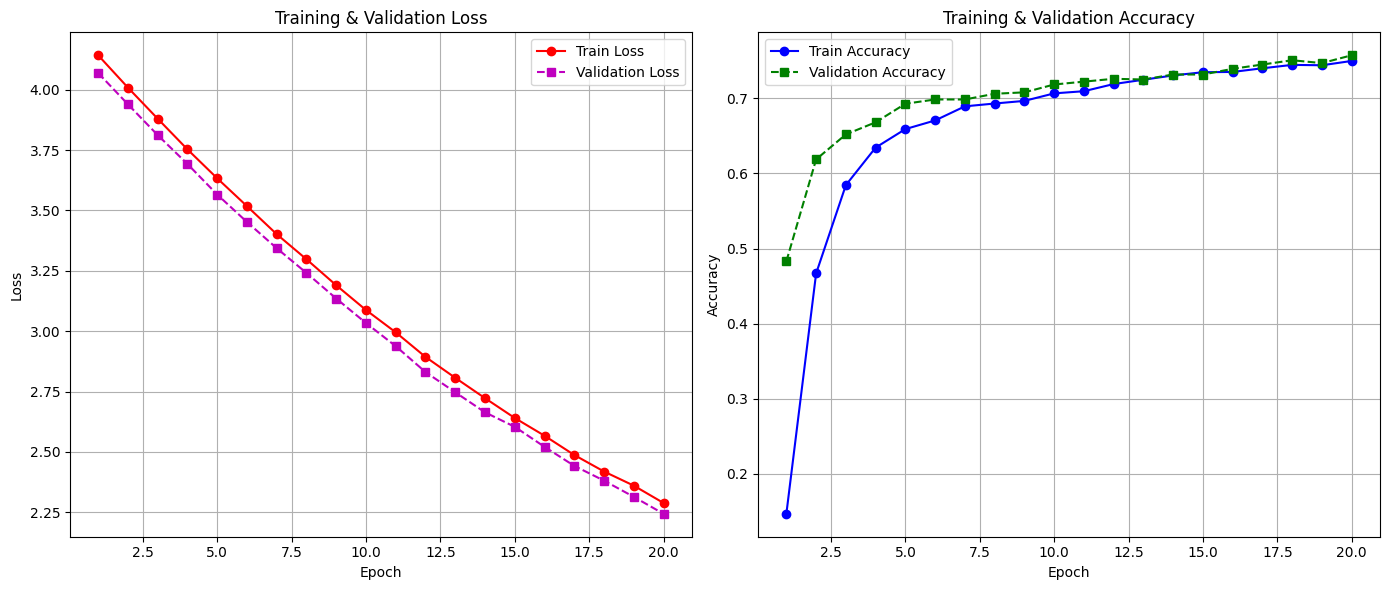


--- Evaluating on Test Set using Best Model ---
Loading best model weights from: best_efficientnet_b4.pth


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_17248\2177502257.py:403: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(config['BEST_MODEL_SAVE_

[Final] Testing (Best Model) Loss: 2.1643, Accuracy: 0.7676

Final Test Accuracy (Best Model): 0.7676
Final Test Loss (Best Model): 2.1643

--- Experiment Complete ---


In [ ]:
import os
import time
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import efficientnet_b4, EfficientNet_B4_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import autocast, GradScaler # Use autocast and GradScaler from torch.cuda.amp
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Configuration ---
config = {
    "DATA_DIR": "dataset/images", # Base directory with train/, val/, test/
    "MODEL_NAME": "efficientnet_b4", # Can be used later to select different models
    "BATCH_SIZE": 64,
    "IMG_SIZE": 384, # Input size expected by EfficientNet-B4
    "NUM_EPOCHS": 20,
    "LEARNING_RATE": 1e-4,
    "WEIGHT_DECAY": 5e-2,
    "DROPOUT_P": 0.4,
    "NUM_WORKERS": 4, # Number of workers for DataLoader
    "PIN_MEMORY": True, # Set based on device later
    "USE_WEIGHTED_LOSS": True, # Attempt to use class weighting
    "FREEZE_BACKBONE": True, # Freeze pre-trained layers initially
    # Paths
    "MODEL_SAVE_PATH": "efficientnet_b4_finetuned.pth", # Final model save path (optional)
    "BEST_MODEL_SAVE_PATH": "best_efficientnet_b4.pth", # Path to save the best model during training
    "MAPPING_SAVE_PATH": "class_mapping.json",
    "PLOT_SAVE_PATH": "training_validation_metrics.png",
}

# --- Helper Functions ---

def get_device():
    """Gets the appropriate device (CUDA or CPU)"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        torch.backends.cudnn.benchmark = True # Enable cuDNN benchmark
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

def get_transforms(img_size, weights):
    """Gets the train and validation/test transforms"""
    # Use normalization parameters from the pre-trained weights
    normalization_mean = weights.transforms().mean
    normalization_std = weights.transforms().std

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=normalization_mean, std=normalization_std),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0) # Optional
    ])

    # Use the standard transforms recommended by the weights for validation/testing
    val_test_transform = weights.transforms()

    print("Train Transforms:", train_transform)
    print("Val/Test Transforms:", val_test_transform)
    return train_transform, val_test_transform

def get_dataloaders(data_dir, batch_size, train_transform, val_test_transform, num_workers, pin_memory, mapping_save_path):
    """Creates datasets and dataloaders for train, val, and test sets."""
    print("Loading datasets...")
    try:
        train_path = os.path.join(data_dir, 'train')
        val_path = os.path.join(data_dir, 'val')
        test_path = os.path.join(data_dir, 'test')

        if not os.path.isdir(train_path):
            raise FileNotFoundError(f"Training directory not found: {train_path}")
        if not os.path.isdir(val_path):
            raise FileNotFoundError(f"Validation directory not found: {val_path}")
        if not os.path.isdir(test_path):
            raise FileNotFoundError(f"Test directory not found: {test_path}")

        train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
        val_dataset = datasets.ImageFolder(val_path, transform=val_test_transform)
        test_dataset = datasets.ImageFolder(test_path, transform=val_test_transform)

        # Determine number of classes and save mapping
        num_classes = len(train_dataset.classes)
        class_mapping = train_dataset.class_to_idx
        print(f"Found {num_classes} classes: {train_dataset.classes}")

        # Save class mapping
        try:
            with open(mapping_save_path, 'w') as f:
                json.dump(class_mapping, f, indent=4)
            print(f"Class mapping saved to: {mapping_save_path}")
        except IOError as e:
            print(f"Warning: Could not save class mapping to {mapping_save_path}: {e}")


        if not train_dataset or not val_dataset or not test_dataset:
            raise ValueError("One or more datasets (train, val, test) are empty.")

        print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
        print("DataLoaders created.")

        return train_loader, val_loader, test_loader, train_dataset, num_classes # Return train_dataset for weight calculation

    except Exception as e:
        print(f"Error loading data: {e}")
        print("Please ensure 'train', 'val', and 'test' subdirectories exist in DATA_DIR and contain images.")
        exit()

def calculate_class_weights(train_dataset, device):
    """Calculates class weights for handling imbalance."""
    print("Calculating class weights...")
    try:
        class_labels = train_dataset.targets
        class_indices = sorted(list(set(class_labels)))

        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.array(class_indices),
            y=np.array(class_labels)
        )
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
        print(f"Class weights calculated (first 5): {class_weights_tensor[:5]}")
        return class_weights_tensor
    except Exception as e:
        print(f"ERROR: Could not calculate class weights: {e}. Using standard loss.")
        return None

def get_model(model_name, num_classes, freeze_backbone=True):
    """Loads a pre-trained model and modifies its classifier."""
    print(f"Loading {model_name} model...")
    if model_name == "efficientnet_b4":
        weights = EfficientNet_B4_Weights.IMAGENET1K_V1
        model = efficientnet_b4(weights=weights)

        if freeze_backbone:
            print("Freezing backbone layers...")
            for param in model.parameters():
                param.requires_grad = False

        # Replace the classifier - new layers automatically have requires_grad=True
        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),
            nn.Linear(in_features, num_classes),
        )

        print("Model classifier replaced.")
        print("Trainable parameters after modification:")
        for name, param in model.named_parameters():
             if param.requires_grad:
                 print(f"- {name}")

        return model, weights # Return weights for transforms
    else:
        raise ValueError(f"Model {model_name} not implemented yet.")


def get_optimizer_scheduler(model, learning_rate, weight_decay):
    """Creates the optimizer and learning rate scheduler."""
    print("Defining Optimizer and Scheduler...")
    # Filter parameters that require gradients
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.AdamW(trainable_params, lr=learning_rate, weight_decay=weight_decay)
    # Reduce LR when validation accuracy plateaus
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)
    print(f"Optimizer: AdamW (LR={learning_rate}, WD={weight_decay})")
    print("Scheduler: ReduceLROnPlateau (Factor=0.1, Patience=3, Mode=max)")
    return optimizer, scheduler

def train_one_epoch(model, loader, criterion, optimizer, scaler, device, epoch_num, num_epochs):
    """Performs one training epoch."""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    is_cuda = device == torch.device("cuda")

    progress_bar = tqdm(loader, desc=f"Epoch {epoch_num}/{num_epochs} [Training]", leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Use autocast only if on CUDA
        with autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        if is_cuda:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else: # No scaling needed for CPU
            loss.backward()
            optimizer.step()


        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Update progress bar
        batch_acc = (predicted == labels).sum().item() / labels.size(0) if labels.size(0) > 0 else 0
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{batch_acc:.4f}")

    epoch_loss = running_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0
    print(f"[Epoch {epoch_num}] Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, loader, criterion, device, phase="Validation", epoch_num=None):
    """Evaluates the model on a given dataset."""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    is_cuda = device == torch.device("cuda")

    epoch_str = f"Epoch {epoch_num}" if epoch_num else "Final"
    progress_bar = tqdm(loader, desc=f"{epoch_str} [{phase}]", leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        with autocast(device_type=device.type, enabled=is_cuda):
            outputs = model(inputs)
            loss = criterion(outputs, labels) # Can still calculate loss for info if needed

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Update progress bar
        batch_acc = (predicted == labels).sum().item() / labels.size(0) if labels.size(0) > 0 else 0
        progress_bar.set_postfix(acc=f"{batch_acc:.4f}")


    epoch_loss = running_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0
    print(f"[{epoch_str}] {phase} Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, save_path):
    """Plots training and validation metrics."""
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss', marker='o', linestyle='-', color='r')
    plt.plot(epochs_range, val_losses, label='Validation Loss', marker='s', linestyle='--', color='m')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o', linestyle='-', color='b')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='s', linestyle='--', color='g')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    try:
        plt.savefig(save_path)
        print(f"Metrics plot saved as {save_path}")
    except Exception as e:
        print(f"Error saving plot: {e}")
    plt.show()


device = get_device()
config["PIN_MEMORY"] = True if device == torch.device("cuda") else False # Adjust pin_memory based on device

# --- Data Loading ---
# Need temporary weights object to get transforms
temp_weights = EfficientNet_B4_Weights.IMAGENET1K_V1
train_transform, val_test_transform = get_transforms(config["IMG_SIZE"], temp_weights)
train_loader, val_loader, test_loader, train_dataset, num_classes = get_dataloaders(
    config["DATA_DIR"],
    config["BATCH_SIZE"],
    train_transform,
    val_test_transform,
    config["NUM_WORKERS"],
    config["PIN_MEMORY"],
    config["MAPPING_SAVE_PATH"]
)

# --- Class Weights (Optional) ---
class_weights_tensor = None
if config["USE_WEIGHTED_LOSS"]:
    class_weights_tensor = calculate_class_weights(train_dataset, device)
    if class_weights_tensor is None:
        print("Proceeding without weighted loss as calculation failed.")

# --- Model ---
model, _ = get_model( # Don't need weights object returned here anymore
    config["MODEL_NAME"],
    num_classes,
    config["FREEZE_BACKBONE"]
)
model.to(device)

# --- Loss Function ---
print("Defining Loss function...")
if config["USE_WEIGHTED_LOSS"] and class_weights_tensor is not None:
    print("Using Weighted CrossEntropyLoss.")
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
else:
    print("Using standard CrossEntropyLoss.")
    criterion = nn.CrossEntropyLoss()

# --- Optimizer and Scheduler ---
optimizer, scheduler = get_optimizer_scheduler(
    model,
    config["LEARNING_RATE"],
    config["WEIGHT_DECAY"]
)

# --- Mixed Precision Scaler ---
# Initialize GradScaler only if on CUDA
scaler = GradScaler(device='cuda')
print(f"Mixed precision enabled: {scaler.is_enabled()}")


# --- Training Loop ---
print("\n--- Starting Training ---")
start_time = time.time()

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_acc = 0.0

for epoch in range(1, config["NUM_EPOCHS"] + 1):
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, scaler, device, epoch, config["NUM_EPOCHS"]
    )
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Validate
    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device, phase="Validation", epoch_num=epoch
    )
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Update LR Scheduler
    if scheduler:
        # scheduler.step(val_loss) # If monitoring loss
        scheduler.step(val_acc) # If monitoring accuracy
    
    last_lr = scheduler.get_last_lr()
    print("Previous LR: ", last_lr)

    # Save Best Model
    if val_acc > best_val_acc:
        print(f"Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}. Saving best model to {config['BEST_MODEL_SAVE_PATH']}...")
        best_val_acc = val_acc
        try:
            torch.save(model.state_dict(), config['BEST_MODEL_SAVE_PATH'])
        except Exception as e:
            print(f"Error saving best model: {e}")

end_time = time.time()
print(f"\n--- Training Finished ---")
print(f"Total Training Time: {(end_time - start_time) / 60:.2f} minutes")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# --- Plotting ---
print("\n--- Plotting Metrics ---")
plot_metrics(
    history['train_loss'], history['val_loss'],
    history['train_acc'], history['val_acc'],
    config["PLOT_SAVE_PATH"]
)

# --- Final Evaluation on Test Set ---
print("\n--- Evaluating on Test Set using Best Model ---")
try:
    # Load the best weights saved during training
    print(f"Loading best model weights from: {config['BEST_MODEL_SAVE_PATH']}")
    model.load_state_dict(torch.load(config['BEST_MODEL_SAVE_PATH'], map_location=device))

    test_loss, test_accuracy = evaluate(
        model, test_loader, criterion, device, phase="Testing (Best Model)"
    )
    print(f"\nFinal Test Accuracy (Best Model): {test_accuracy:.4f}")
    print(f"Final Test Loss (Best Model): {test_loss:.4f}")

except FileNotFoundError:
    print(f"Warning: Best model file '{config['BEST_MODEL_SAVE_PATH']}' not found.")
    print("Evaluating using the model from the final epoch instead.")
    # Evaluate the model as it is (from the last epoch)
    test_loss, test_accuracy = evaluate(
        model, test_loader, criterion, device, phase="Testing (Final Epoch Model)"
    )
    print(f"\nFinal Test Accuracy (Final Epoch Model): {test_accuracy:.4f}")
    print(f"Final Test Loss (Final Epoch Model): {test_loss:.4f}")

except Exception as e:
    print(f"An error occurred during final evaluation: {e}")

# Optional: Save the final model state if needed
# print(f"Saving final model state to {config['MODEL_SAVE_PATH']}")
# torch.save(model.state_dict(), config['MODEL_SAVE_PATH'])

print("\n--- Experiment Complete ---")

#### Efficientnetb0 with updated script

In [4]:
import os
import time
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import autocast, GradScaler # Use autocast and GradScaler from torch.cuda.amp
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# --- Configuration ---
config = {
    "DATA_DIR": "dataset/images", # Base directory with train/, val/, test/
    "MODEL_NAME": "efficientnet_b0", # Can be used later to select different models
    "BATCH_SIZE": 32,
    "IMG_SIZE": 224, # Input size expected by EfficientNet-B4
    "NUM_EPOCHS": 20,
    "LEARNING_RATE": 1e-4,
    "WEIGHT_DECAY": 5e-2,
    "DROPOUT_P": 0.4,
    "NUM_WORKERS": 4, # Number of workers for DataLoader
    "PIN_MEMORY": True, # Set based on device later
    "USE_WEIGHTED_LOSS": True, # Attempt to use class weighting
    "FREEZE_BACKBONE": True, # Freeze pre-trained layers initially
    # Paths
    "MODEL_SAVE_PATH": "efficientnet_b0_finetuned.pth", # Final model save path (optional)
    "BEST_MODEL_SAVE_PATH": "best_efficientnet_b0.pth", # Path to save the best model during training
    "MAPPING_SAVE_PATH": "class_mapping.json",
    "PLOT_SAVE_PATH": "training_validation_metrics.png",
}

# --- Helper Functions ---

def get_device():
    """Gets the appropriate device (CUDA or CPU)"""
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using GPU: {torch.cuda.get_device_name(0)}")
        torch.backends.cudnn.benchmark = True # Enable cuDNN benchmark
    else:
        device = torch.device("cpu")
        print("Using CPU")
    return device

def get_transforms(img_size, weights):
    """Gets the train and validation/test transforms"""
    # Use normalization parameters from the pre-trained weights
    normalization_mean = weights.transforms().mean
    normalization_std = weights.transforms().std

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=normalization_mean, std=normalization_std),
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0) # Optional
    ])

    # Use the standard transforms recommended by the weights for validation/testing
    val_test_transform = weights.transforms()

    print("Train Transforms:", train_transform)
    print("Val/Test Transforms:", val_test_transform)
    return train_transform, val_test_transform

def get_dataloaders(data_dir, batch_size, train_transform, val_test_transform, num_workers, pin_memory, mapping_save_path):
    """Creates datasets and dataloaders for train, val, and test sets."""
    print("Loading datasets...")
    try:
        train_path = os.path.join(data_dir, 'train')
        val_path = os.path.join(data_dir, 'val')
        test_path = os.path.join(data_dir, 'test')

        if not os.path.isdir(train_path):
            raise FileNotFoundError(f"Training directory not found: {train_path}")
        if not os.path.isdir(val_path):
            raise FileNotFoundError(f"Validation directory not found: {val_path}")
        if not os.path.isdir(test_path):
            raise FileNotFoundError(f"Test directory not found: {test_path}")

        train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
        val_dataset = datasets.ImageFolder(val_path, transform=val_test_transform)
        test_dataset = datasets.ImageFolder(test_path, transform=val_test_transform)

        # Determine number of classes and save mapping
        num_classes = len(train_dataset.classes)
        class_mapping = train_dataset.class_to_idx
        print(f"Found {num_classes} classes: {train_dataset.classes}")

        # Save class mapping
        try:
            with open(mapping_save_path, 'w') as f:
                json.dump(class_mapping, f, indent=4)
            print(f"Class mapping saved to: {mapping_save_path}")
        except IOError as e:
            print(f"Warning: Could not save class mapping to {mapping_save_path}: {e}")


        if not train_dataset or not val_dataset or not test_dataset:
            raise ValueError("One or more datasets (train, val, test) are empty.")

        print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)
        print("DataLoaders created.")

        return train_loader, val_loader, test_loader, train_dataset, num_classes # Return train_dataset for weight calculation

    except Exception as e:
        print(f"Error loading data: {e}")
        print("Please ensure 'train', 'val', and 'test' subdirectories exist in DATA_DIR and contain images.")
        exit()

def calculate_class_weights(train_dataset, device):
    """Calculates class weights for handling imbalance."""
    print("Calculating class weights...")
    try:
        class_labels = train_dataset.targets
        class_indices = sorted(list(set(class_labels)))

        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.array(class_indices),
            y=np.array(class_labels)
        )
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
        print(f"Class weights calculated (first 5): {class_weights_tensor[:5]}")
        return class_weights_tensor
    except Exception as e:
        print(f"ERROR: Could not calculate class weights: {e}. Using standard loss.")
        return None

def get_model(model_name, num_classes, freeze_backbone=True):
    """Loads a pre-trained model and modifies its classifier."""
    print(f"Loading {model_name} model...")
    if model_name == "efficientnet_b0":
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1
        model = efficientnet_b0(weights=weights)

        if freeze_backbone:
            print("Freezing backbone layers...")
            for param in model.parameters():
                param.requires_grad = False

        # Replace the classifier - new layers automatically have requires_grad=True
        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.4, inplace=True),
            nn.Linear(in_features, num_classes),
        )

        print("Model classifier replaced.")
        print("Trainable parameters after modification:")
        for name, param in model.named_parameters():
             if param.requires_grad:
                 print(f"- {name}")

        return model, weights # Return weights for transforms
    else:
        raise ValueError(f"Model {model_name} not implemented yet.")


def get_optimizer_scheduler(model, learning_rate, weight_decay):
    """Creates the optimizer and learning rate scheduler."""
    print("Defining Optimizer and Scheduler...")
    # Filter parameters that require gradients
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.AdamW(trainable_params, lr=learning_rate, weight_decay=weight_decay)
    # Reduce LR when validation accuracy plateaus
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)
    print(f"Optimizer: AdamW (LR={learning_rate}, WD={weight_decay})")
    print("Scheduler: ReduceLROnPlateau (Factor=0.1, Patience=3, Mode=max)")
    return optimizer, scheduler

def train_one_epoch(model, loader, criterion, optimizer, scaler, device, epoch_num, num_epochs):
    """Performs one training epoch."""
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    is_cuda = device == torch.device("cuda")

    progress_bar = tqdm(loader, desc=f"Epoch {epoch_num}/{num_epochs} [Training]", leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Use autocast only if on CUDA
        with autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        if is_cuda:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else: # No scaling needed for CPU
            loss.backward()
            optimizer.step()


        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Update progress bar
        batch_acc = (predicted == labels).sum().item() / labels.size(0) if labels.size(0) > 0 else 0
        progress_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{batch_acc:.4f}")

    epoch_loss = running_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0
    print(f"[Epoch {epoch_num}] Train Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, loader, criterion, device, phase="Validation", epoch_num=None):
    """Evaluates the model on a given dataset."""
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    is_cuda = device == torch.device("cuda")

    epoch_str = f"Epoch {epoch_num}" if epoch_num else "Final"
    progress_bar = tqdm(loader, desc=f"{epoch_str} [{phase}]", leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        with autocast(device_type=device.type, enabled=is_cuda):
            outputs = model(inputs)
            loss = criterion(outputs, labels) # Can still calculate loss for info if needed

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        # Update progress bar
        batch_acc = (predicted == labels).sum().item() / labels.size(0) if labels.size(0) > 0 else 0
        progress_bar.set_postfix(acc=f"{batch_acc:.4f}")


    epoch_loss = running_loss / total_samples if total_samples > 0 else 0
    epoch_acc = correct_predictions / total_samples if total_samples > 0 else 0
    print(f"[{epoch_str}] {phase} Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
    return epoch_loss, epoch_acc

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies, save_path):
    """Plots training and validation metrics."""
    epochs_range = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 6))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Train Loss', marker='o', linestyle='-', color='r')
    plt.plot(epochs_range, val_losses, label='Validation Loss', marker='s', linestyle='--', color='m')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o', linestyle='-', color='b')
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', marker='s', linestyle='--', color='g')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    try:
        plt.savefig(save_path)
        print(f"Metrics plot saved as {save_path}")
    except Exception as e:
        print(f"Error saving plot: {e}")
    plt.show()


device = get_device()
config["PIN_MEMORY"] = True if device == torch.device("cuda") else False # Adjust pin_memory based on device

# --- Data Loading ---
# Need temporary weights object to get transforms
temp_weights = EfficientNet_B0_Weights.IMAGENET1K_V1
train_transform, val_test_transform = get_transforms(config["IMG_SIZE"], temp_weights)
train_loader, val_loader, test_loader, train_dataset, num_classes = get_dataloaders(
    config["DATA_DIR"],
    config["BATCH_SIZE"],
    train_transform,
    val_test_transform,
    config["NUM_WORKERS"],
    config["PIN_MEMORY"],
    config["MAPPING_SAVE_PATH"]
)

# --- Class Weights (Optional) ---
class_weights_tensor = None
if config["USE_WEIGHTED_LOSS"]:
    class_weights_tensor = calculate_class_weights(train_dataset, device)
    if class_weights_tensor is None:
        print("Proceeding without weighted loss as calculation failed.")

# --- Model ---
model, _ = get_model( # Don't need weights object returned here anymore
    config["MODEL_NAME"],
    num_classes,
    config["FREEZE_BACKBONE"]
)
model.to(device)

# --- Loss Function ---
print("Defining Loss function...")
if config["USE_WEIGHTED_LOSS"] and class_weights_tensor is not None:
    print("Using Weighted CrossEntropyLoss.")
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
else:
    print("Using standard CrossEntropyLoss.")
    criterion = nn.CrossEntropyLoss()

# --- Optimizer and Scheduler ---
optimizer, scheduler = get_optimizer_scheduler(
    model,
    config["LEARNING_RATE"],
    config["WEIGHT_DECAY"]
)

# --- Mixed Precision Scaler ---
# Initialize GradScaler only if on CUDA
scaler = GradScaler(device='cuda')
print(f"Mixed precision enabled: {scaler.is_enabled()}")


# --- Training Loop ---
print("\n--- Starting Training ---")
start_time = time.time()

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_acc = 0.0

for epoch in range(1, config["NUM_EPOCHS"] + 1):
    # Train
    train_loss, train_acc = train_one_epoch(
        model, train_loader, criterion, optimizer, scaler, device, epoch, config["NUM_EPOCHS"]
    )
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Validate
    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device, phase="Validation", epoch_num=epoch
    )
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Update LR Scheduler
    if scheduler:
        # scheduler.step(val_loss) # If monitoring loss
        scheduler.step(val_acc) # If monitoring accuracy
    
    current_lr = scheduler.get_last_lr()
    print("Current LR: ", current_lr)

    # Save Best Model
    if val_acc > best_val_acc:
        print(f"Validation accuracy improved from {best_val_acc:.4f} to {val_acc:.4f}. Saving best model to {config['BEST_MODEL_SAVE_PATH']}...")
        best_val_acc = val_acc
        try:
            torch.save(model.state_dict(), config['BEST_MODEL_SAVE_PATH'])
        except Exception as e:
            print(f"Error saving best model: {e}")

end_time = time.time()
print(f"\n--- Training Finished ---")
print(f"Total Training Time: {(end_time - start_time) / 60:.2f} minutes")
print(f"Best Validation Accuracy: {best_val_acc:.4f}")

# --- Plotting ---
print("\n--- Plotting Metrics ---")
plot_metrics(
    history['train_loss'], history['val_loss'],
    history['train_acc'], history['val_acc'],
    config["PLOT_SAVE_PATH"]
)

# --- Final Evaluation on Test Set ---
print("\n--- Evaluating on Test Set using Best Model ---")
try:
    # Load the best weights saved during training
    print(f"Loading best model weights from: {config['BEST_MODEL_SAVE_PATH']}")
    model.load_state_dict(torch.load(config['BEST_MODEL_SAVE_PATH'], map_location=device))

    test_loss, test_accuracy = evaluate(
        model, test_loader, criterion, device, phase="Testing (Best Model)"
    )
    print(f"\nFinal Test Accuracy (Best Model): {test_accuracy:.4f}")
    print(f"Final Test Loss (Best Model): {test_loss:.4f}")

except FileNotFoundError:
    print(f"Warning: Best model file '{config['BEST_MODEL_SAVE_PATH']}' not found.")
    print("Evaluating using the model from the final epoch instead.")
    # Evaluate the model as it is (from the last epoch)
    test_loss, test_accuracy = evaluate(
        model, test_loader, criterion, device, phase="Testing (Final Epoch Model)"
    )
    print(f"\nFinal Test Accuracy (Final Epoch Model): {test_accuracy:.4f}")
    print(f"Final Test Loss (Final Epoch Model): {test_loss:.4f}")

except Exception as e:
    print(f"An error occurred during final evaluation: {e}")

# Optional: Save the final model state if needed
# print(f"Saving final model state to {config['MODEL_SAVE_PATH']}")
# torch.save(model.state_dict(), config['MODEL_SAVE_PATH'])

print("\n--- Experiment Complete ---")

Using GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Train Transforms: Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    RandomErasing(p=0.2, scale=(0.02, 0.1), ratio=(0.3, 3.3), value=0, inplace=False)
)
Val/Test Transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
Loading datasets...
Found 67 classes: ['Apple', 'Artichoke', 'Balaleet', 'Bamya', 'Banana', 'Basbousa', 'Bell pepper', 'Broccoli', 'Burger', 'Carrot', 'Crab', 'Cucumber', 'Dajaj_Mahshi', 'Dates_with_tahini', 'Fattoush', 'Fries', 'Gers_Ogaily', 'Grape', 'Harees', 'Hot Dog', 'Hummus', 'Jireesh', 'Kebab', 'Kubba', 'Labneh', 'Le

c:\Work\Garbage_classification\food-recognition\food-recognition\env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Defining Loss function...
Using Weighted CrossEntropyLoss.
Defining Optimizer and Scheduler...
Optimizer: AdamW (LR=0.0001, WD=0.05)
Scheduler: ReduceLROnPlateau (Factor=0.1, Patience=3, Mode=max)
Mixed precision enabled: True

--- Starting Training ---


[Epoch 1] Train Loss: 4.0053, Accuracy: 0.1120


[Epoch 1] Validation Loss: 3.7344, Accuracy: 0.3916
Current LR:  [0.0001]
Validation accuracy improved from 0.0000 to 0.3916. Saving best model to best_efficientnet_b0.pth...


[Epoch 2] Train Loss: 3.5697, Accuracy: 0.3738


[Epoch 2] Validation Loss: 3.3549, Accuracy: 0.5513
Current LR:  [0.0001]
Validation accuracy improved from 0.3916 to 0.5513. Saving best model to best_efficientnet_b0.pth...


[Epoch 3] Train Loss: 3.2199, Accuracy: 0.5088


[Epoch 3] Validation Loss: 3.0336, Accuracy: 0.6131
Current LR:  [0.0001]
Validation accuracy improved from 0.5513 to 0.6131. Saving best model to best_efficientnet_b0.pth...


[Epoch 4] Train Loss: 2.9176, Accuracy: 0.5736


[Epoch 4] Validation Loss: 2.7633, Accuracy: 0.6483
Current LR:  [0.0001]
Validation accuracy improved from 0.6131 to 0.6483. Saving best model to best_efficientnet_b0.pth...


[Epoch 5] Train Loss: 2.6660, Accuracy: 0.6146


[Epoch 5] Validation Loss: 2.5340, Accuracy: 0.6578
Current LR:  [0.0001]
Validation accuracy improved from 0.6483 to 0.6578. Saving best model to best_efficientnet_b0.pth...


[Epoch 6] Train Loss: 2.4673, Accuracy: 0.6312


[Epoch 6] Validation Loss: 2.3223, Accuracy: 0.6768
Current LR:  [0.0001]
Validation accuracy improved from 0.6578 to 0.6768. Saving best model to best_efficientnet_b0.pth...


[Epoch 7] Train Loss: 2.2937, Accuracy: 0.6449


[Epoch 7] Validation Loss: 2.1746, Accuracy: 0.6854
Current LR:  [0.0001]
Validation accuracy improved from 0.6768 to 0.6854. Saving best model to best_efficientnet_b0.pth...


[Epoch 8] Train Loss: 2.1429, Accuracy: 0.6552


[Epoch 8] Validation Loss: 2.0063, Accuracy: 0.6873
Current LR:  [0.0001]
Validation accuracy improved from 0.6854 to 0.6873. Saving best model to best_efficientnet_b0.pth...


[Epoch 9] Train Loss: 2.0123, Accuracy: 0.6682


[Epoch 9] Validation Loss: 1.9453, Accuracy: 0.6873
Current LR:  [0.0001]


[Epoch 10] Train Loss: 1.9110, Accuracy: 0.6775


[Epoch 10] Validation Loss: 1.8122, Accuracy: 0.6949
Current LR:  [0.0001]
Validation accuracy improved from 0.6873 to 0.6949. Saving best model to best_efficientnet_b0.pth...


KeyboardInterrupt: 

### Confusion matrix and 

In [2]:
### Inference on a single image
import os
import json
import torch
import torch.nn as nn
from torchvision.models import EfficientNet_V2_S_Weights, efficientnet_v2_s
from PIL import Image

# --- Configuration ---
MODEL_PATH = 'models/best_model.pth'
# IMAGE_PATH = r'dataset\images\test\Hummus\18.jpg'  # <<<--- Change this to your image file
IMAGE_PATH = r"C:\Work\Garbage_classification\food-recognition\food-recognition\dataset\images\test\Hummus\133.jpg"
MAPPING_JSON_PATH = 'class_mapping.json'
NUM_CLASSES = 66

# --- Device Setup ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# --- Load Class Mapping ---
print(f"Loading class mapping from: {MAPPING_JSON_PATH}")
try:
    with open(MAPPING_JSON_PATH, 'r') as f:
        class_to_idx = json.load(f)
    idx_to_class = {v: k for k, v in class_to_idx.items()}
    if len(idx_to_class) != NUM_CLASSES:
        print(f"Warning: Found {len(idx_to_class)} classes, expected {NUM_CLASSES}")
except Exception as e:
    raise RuntimeError(f"Failed to load class mapping: {e}")

# --- Load Model ---
print("Loading model...")
weights = EfficientNet_V2_S_Weights.IMAGENET1K_V1
model = efficientnet_v2_s(weights=weights)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Dropout(p=0.37, inplace=True), # Keep dropout
    nn.Linear(num_ftrs, NUM_CLASSES),
)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# --- Preprocessing ---
preprocess = weights.transforms()

# --- Prediction Function ---
def predict_image(image_path):
    try:
        img = Image.open(image_path).convert('RGB')
        input_tensor = preprocess(img).unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            output = model(input_tensor)
            conf, idx = torch.max(torch.softmax(output, dim=1), 1)
        return idx_to_class.get(idx.item(), "Unknown"), conf.item()
    except Exception as e:
        print(f"Prediction error: {e}")
        return None, None

# --- Inference ---
if not os.path.exists(IMAGE_PATH):
    print(f"Image path does not exist: {IMAGE_PATH}")
else:
    print(f"Predicting image: {IMAGE_PATH}")
    label, confidence = predict_image(IMAGE_PATH)
    if label:
        print(f"-> Predicted Class: {label}")
        print(f"-> Confidence: {confidence:.4f}")

Using device: cuda
Loading class mapping from: class_mapping.json
Loading model...


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20260\3730462992.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_location=

Predicting image: C:\Work\Garbage_classification\food-recognition\food-recognition\dataset\images\test\Hummus\133.jpg
-> Predicted Class: Hummus
-> Confidence: 0.9627


In [3]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# --- Classification Report and Confusion Matrix ---
print("\n--- Classification Report and Confusion Matrix ---")

# Put model in evaluation mode
model.eval()

# Lists to collect true and predicted labels
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Generating predictions"):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with autocast("cuda"):
            outputs = model(inputs)

        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Load class names
class_names = [class_name for class_name, _ in sorted(train_dataset.class_to_idx.items(), key=lambda x: x[1])]

# Classification report
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))


--- Classification Report and Confusion Matrix ---


Generating predictions: 100%|██████████| 42/42 [00:19<00:00,  2.13it/s]

                              precision    recall  f1-score   support

                       Apple     0.9565    0.7097    0.8148        31
                   Artichoke     1.0000    1.0000    1.0000        27
                    Balaleet     1.0000    0.9231    0.9600        13
                       Bamya     0.7600    1.0000    0.8636        19
                      Banana     1.0000    1.0000    1.0000        31
                    Basbousa     0.9333    0.9333    0.9333        15
                 Bell pepper     1.0000    0.9677    0.9836        31
                    Broccoli     0.9394    1.0000    0.9688        31
                      Burger     0.9667    0.9355    0.9508        31
                      Carrot     0.9091    0.9677    0.9375        31
                        Crab     0.9062    0.9355    0.9206        31
                    Cucumber     0.9259    0.9615    0.9434        26
                Dajaj_Mahshi     0.6667    0.8000    0.7273         5
           Dates_wi


c:\Work\Garbage_classification\food-recognition\food-recognition\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Work\Garbage_classification\food-recognition\food-recognition\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Work\Garbage_classification\food-recognition\food-recognition\env\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to con

Generating predictions: 100%|██████████| 42/42 [00:16<00:00,  2.57it/s]


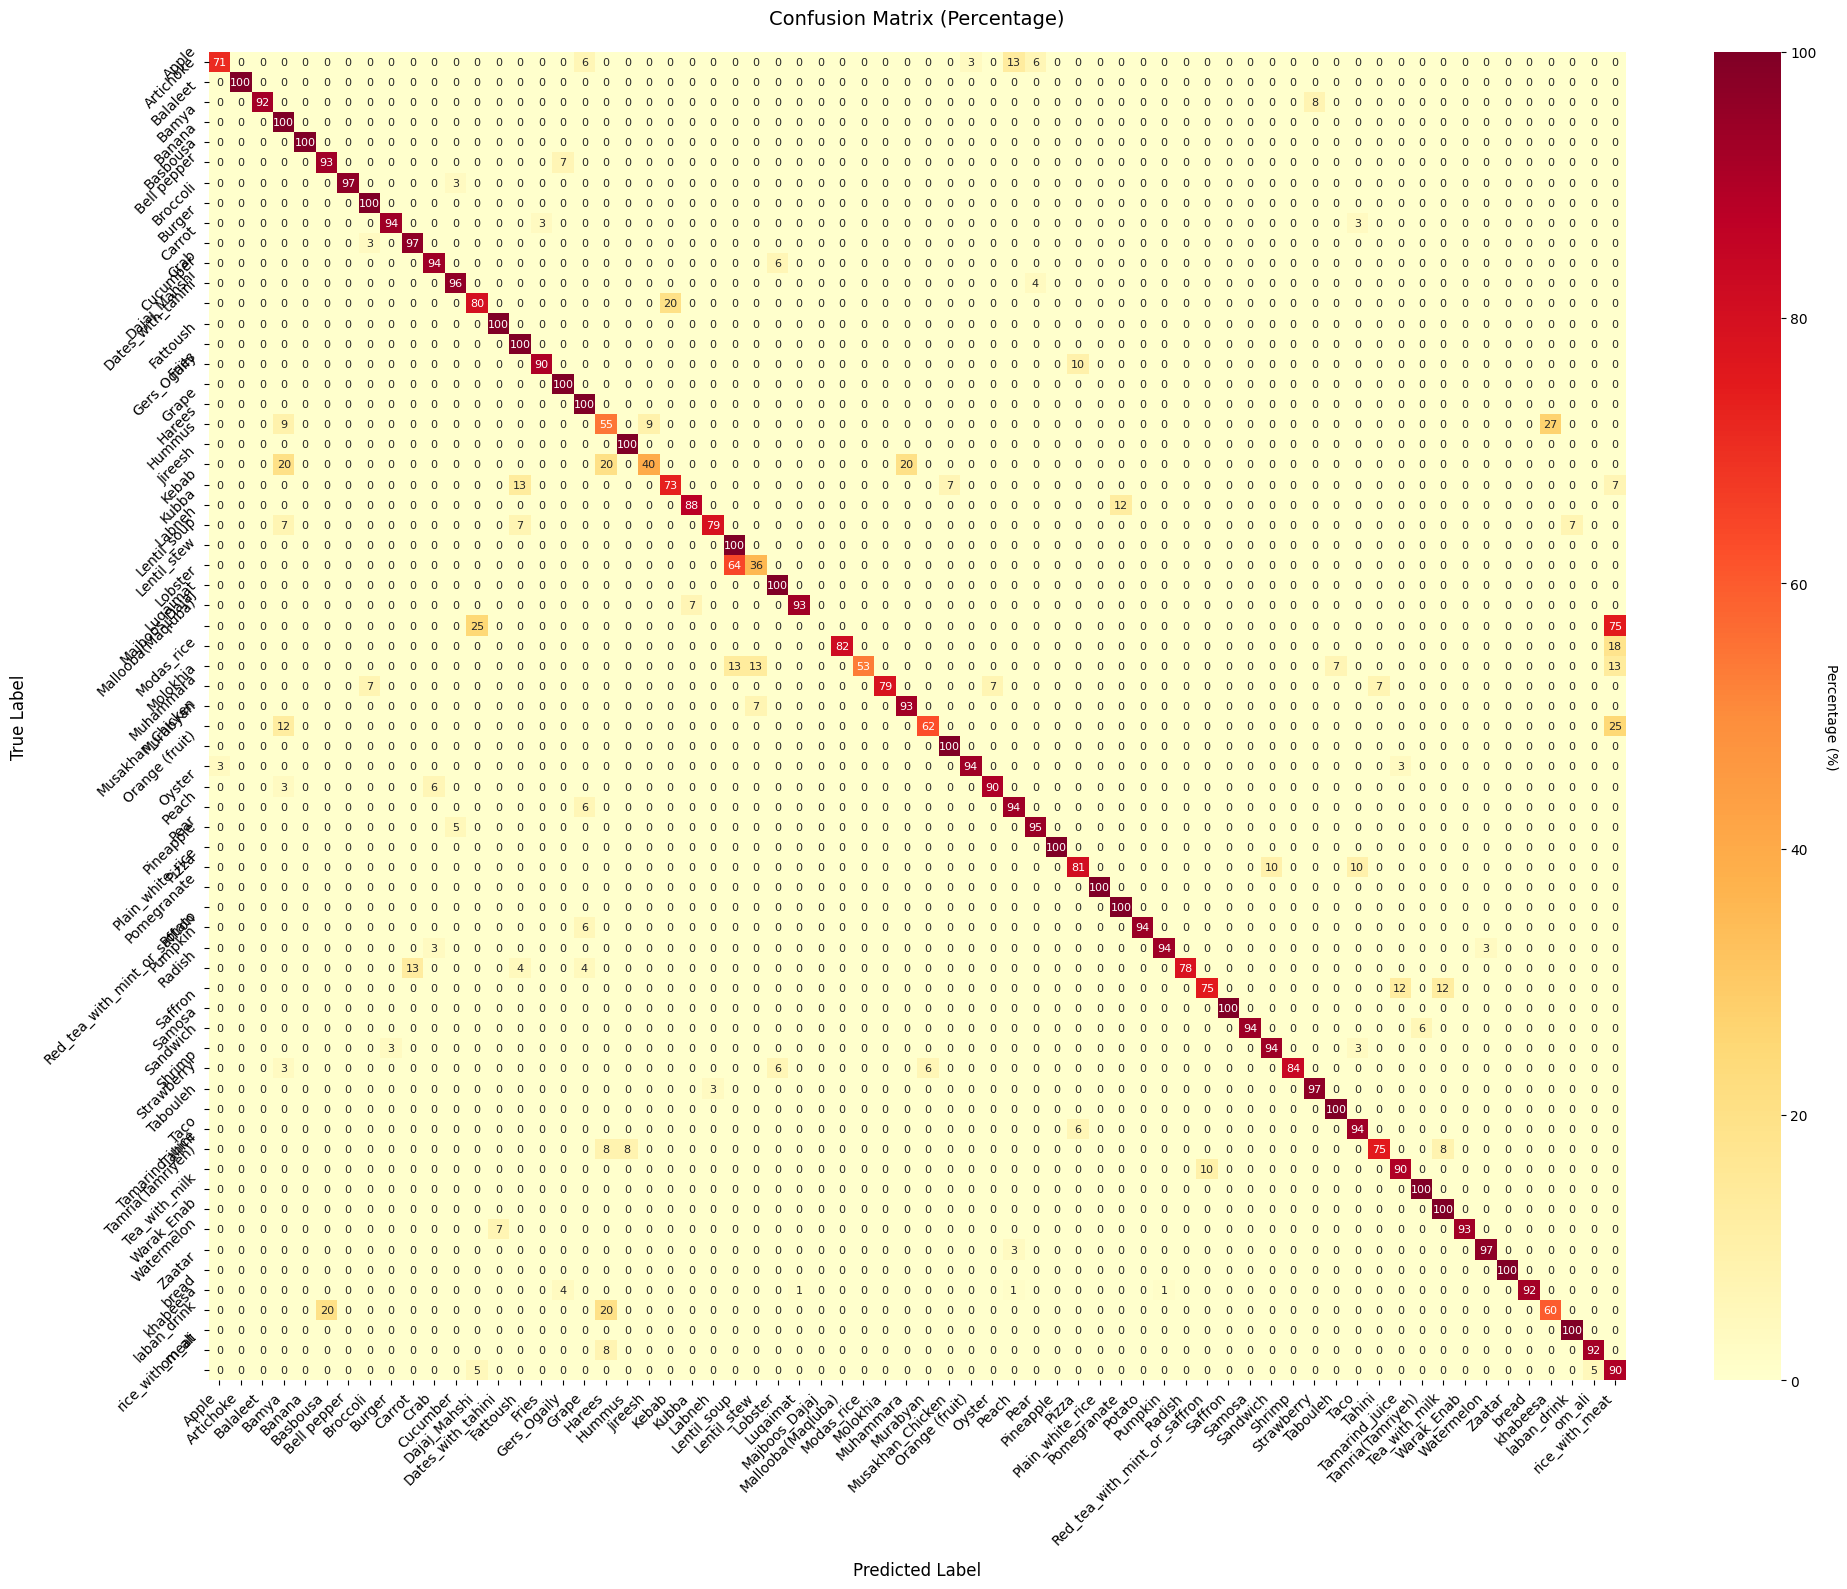


Misclassification Analysis:
--------------------------------------------------------------------------------

True Class: Apple
  → Predicted as Peach: 4 times
  → Predicted as Grape: 2 times
  → Predicted as Pear: 2 times
  → Predicted as Orange (fruit): 1 times

True Class: Balaleet
  → Predicted as Strawberry: 1 times

True Class: Basbousa
  → Predicted as Gers_Ogaily: 1 times

True Class: Bell pepper
  → Predicted as Cucumber: 1 times

True Class: Burger
  → Predicted as Taco: 1 times
  → Predicted as Fries: 1 times

True Class: Carrot
  → Predicted as Broccoli: 1 times

True Class: Crab
  → Predicted as Lobster: 2 times

True Class: Cucumber
  → Predicted as Pear: 1 times

True Class: Dajaj_Mahshi
  → Predicted as Kebab: 1 times

True Class: Fries
  → Predicted as Pizza: 3 times

True Class: Harees
  → Predicted as khabeesa: 3 times
  → Predicted as Jireesh: 1 times
  → Predicted as Bamya: 1 times

True Class: Jireesh
  → Predicted as Muhammara: 1 times
  → Predicted as Harees: 1

In [7]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

def plot_confusion_matrix(y_true, y_pred, class_names, figure_size=(20, 16)):
    """
    Create a better visualization of the confusion matrix.
    
    Args:
        y_true: True labels
        y_pred: Predicted labels
        class_names: List of class names
        figure_size: Size of the figure (width, height)
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Convert to percentage for better visualization
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Create figure
    plt.figure(figsize=figure_size)
    
    # Create heatmap
    sns.heatmap(cm_percent, 
                annot=True,
                fmt='.1f' if cm_percent.max() < 100 else '.0f',
                cmap='YlOrRd',
                xticklabels=class_names,
                yticklabels=class_names,
                annot_kws={'size': 8})
    
    # Rotate labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45, ha='right')
    
    # Add labels and title
    plt.xlabel('Predicted Label', fontsize=12, labelpad=10)
    plt.ylabel('True Label', fontsize=12, labelpad=10)
    plt.title('Confusion Matrix (Percentage)', fontsize=14, pad=20)
    
    # Add colorbar label
    cbar = plt.gca().collections[0].colorbar
    cbar.set_label('Percentage (%)', rotation=270, labelpad=15)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Save high-resolution figure
    plt.savefig('confusion_matrix_enhanced.png', 
                dpi=300, 
                bbox_inches='tight')
    plt.show()

# Use the function with your existing code
with torch.no_grad():
    all_preds = []
    all_labels = []
    
    for inputs, labels in tqdm(test_loader, desc="Generating predictions"):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        
        with autocast("cuda"):
            outputs = model(inputs)
        
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Get class names
class_names = [class_name for class_name, _ in sorted(train_dataset.class_to_idx.items(), key=lambda x: x[1])]

# Plot enhanced confusion matrix
plot_confusion_matrix(all_labels, all_preds, class_names)

# Additionally, you can create a detailed analysis of misclassifications
def analyze_misclassifications(y_true, y_pred, class_names):
    """
    Create a detailed analysis of misclassifications.
    """
    misclassification_stats = {}
    
    for true_label, pred_label in zip(y_true, y_pred):
        if true_label != pred_label:
            true_class = class_names[true_label]
            pred_class = class_names[pred_label]
            
            if true_class not in misclassification_stats:
                misclassification_stats[true_class] = {}
            
            if pred_class not in misclassification_stats[true_class]:
                misclassification_stats[true_class][pred_class] = 0
                
            misclassification_stats[true_class][pred_class] += 1
    
    # Print the analysis
    print("\nMisclassification Analysis:")
    print("-" * 80)
    for true_class in sorted(misclassification_stats.keys()):
        print(f"\nTrue Class: {true_class}")
        sorted_mistakes = sorted(misclassification_stats[true_class].items(), 
                               key=lambda x: x[1], 
                               reverse=True)
        for pred_class, count in sorted_mistakes[:5]:  # Show top 5 misclassifications
            print(f"  → Predicted as {pred_class}: {count} times")
    
    return misclassification_stats

# Run misclassification analysis
misclassification_stats = analyze_misclassifications(all_labels, all_preds, class_names)